# T-SNE visualization with inception feature extraction of CIFAR-10

## Dependencies
* numpy
* tensorflow
* keras
* keras_vggface
* scikit-learn
* matplotlib
* glob
* PIL

### CIFAR-10 data visualization with T-SNE
The CIFAR-10 dataset consists of 60000 32x32 color images in 10 classes, with 6000 images per class. 
<br>
As its very compute intesive to use all the data so choosen 1000 images at random from the data set. This image dataset is subset of the CIFAR-10 data set. Chosen this particular data set to get a large number of lower resolution image data. This is a very good example of 10 different categories of data. This data set doesn't have any labels so analyzing the 1000 images manually is tedious with such low resolution images hence would be perfect choice to apply SOM techniques like T-SNE to get the pattern in data that to in visualized form.
<br>
<br>
It takes about 50 minutes for inception feature extraction and T-SNE(t-Distributed Stochastic Neighbor Embedding) run with 1000 images. 
(Approx time on Intel i7 3.2GHz with 16 GB RAM )

#### The 32x32 images are of have the following classes
* plane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck


#### The images can be obtained from:
http://www.cs.toronto.edu/~kriz/cifar.html or https://www.kaggle.com/c/cifar-10/data


### Inception feature extraction model:
After Google released their own framework called TensorFlow for neural network in November 2015. Recently, a network termed inception-v3 trained on the ILSVRC-2012 dataset has been made publicly available for TensorFlow. Inception-v3 is trained for the ImageNet Large Visual Recognition Challenge using the data from 2012. This is a standard task in computer vision, where models try to classify entire images into 1000 classes, like "Zebra", "Dalmatian", and "Dishwasher". Instead of building a CNN from scratch, I have used transfer learning to leverage a pre-trained CNN that has demonstrated state-of-the-art performance in object classification tasks.
This network achieves an astonishing top-5 error rate of 3.6%. 
<br>
Hence choose this model for feature extraction. 

In [51]:
from time import time
import numpy as np
import tensorflow as tf
from PIL import Image
from sklearn.manifold import TSNE
import os, re, glob, pickle

In [52]:
from keras.engine import  Model
from keras.layers import Input
from keras_vggface.vggface import VGGFace
from keras.preprocessing import image
from keras_vggface import utils

import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [53]:
# custom paramers: change these parameters to properly run on your machine
image_path = 'C:\\Machine_learning\\data_clean\\train\\melanoma/' # addres of images

#### Path of the foolder where images have been saved on the system
* "samp/" folder ( relative path to the jupyter notebook)

In [54]:
no_of_images = 2000 # number of images. 

#### no_of_images: Can change this parameter to run with less number of images

In [55]:
ellipside =True # elipsoid or rectangular visualization

#### elipsoid or rectangular visualization
* Using ellipside visualization gives better understanding of the overall indivisual clusters 
* Whereas with rectangular, we get a more space optimized & merged image 

In [56]:
image_width = 64 # width and height of each visualized images

In [57]:
feature_extraction = 'inception' # feature extraction method; raw or inception or vgg

#### Choosing the feature extraction method
* The features have been extracted using a inception model. 
* We load the data from the samp/ folder with initial seed of 1000 images
* Will be plotting the final image in Ellipside format instead of rectangular flat.

In [58]:
# find all images
image_names  = glob.glob(image_path + "*.png") 
image_names +=glob.glob(image_path + "*.jpg")
image_names +=glob.glob(image_path + "*.gif")


* Using glob to gather all the image name 

In [59]:
# Let's display the internal variables to make sure all the images are getting processed properly
print(image_names)
print(image_path)

['C:\\Machine_learning\\data_clean\\train\\melanoma\\ISIC_0000000.jpg', 'C:\\Machine_learning\\data_clean\\train\\melanoma\\ISIC_0000001.jpg', 'C:\\Machine_learning\\data_clean\\train\\melanoma\\ISIC_0000002.jpg', 'C:\\Machine_learning\\data_clean\\train\\melanoma\\ISIC_0000003.jpg', 'C:\\Machine_learning\\data_clean\\train\\melanoma\\ISIC_0000004.jpg', 'C:\\Machine_learning\\data_clean\\train\\melanoma\\ISIC_0000006.jpg', 'C:\\Machine_learning\\data_clean\\train\\melanoma\\ISIC_0000007.jpg', 'C:\\Machine_learning\\data_clean\\train\\melanoma\\ISIC_0000008.jpg', 'C:\\Machine_learning\\data_clean\\train\\melanoma\\ISIC_0000009.jpg', 'C:\\Machine_learning\\data_clean\\train\\melanoma\\ISIC_0000010.jpg', 'C:\\Machine_learning\\data_clean\\train\\melanoma\\ISIC_0000011.jpg', 'C:\\Machine_learning\\data_clean\\train\\melanoma\\ISIC_0000012.jpg', 'C:\\Machine_learning\\data_clean\\train\\melanoma\\ISIC_0000013.jpg', 'C:\\Machine_learning\\data_clean\\train\\melanoma\\ISIC_0000014.jpg', 'C:\\

In [60]:
# suffle images
np.random.seed(3)
np.random.shuffle(image_names)

* Modifing the sequence in-place by shuffling the contents to avoid any bias.

In [61]:
if no_of_images > len(image_names):
    no_of_images = len(image_names)
image_names = image_names[:no_of_images]

* Checking if the no_of_images is set higher than actual number of images in the folder

In [62]:


# Google inception pre-trained network
if feature_extraction == 'inception':
    print('using %s network/method for feature extraction'%feature_extraction)
    import sys, tarfile
    from six.moves import urllib
    model_dir =  'C:\\Machine_learning\\Data\\models'
    DATA_URL = 'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'
    def create_graph():

        """Creates a graph from saved GraphDef file and returns a saver."""
        # Creates graph from saved graph_def.pb.
        with tf.gfile.FastGFile(os.path.join(
          model_dir, 'classify_image_graph_def.pb'), 'rb') as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())
            _ = tf.import_graph_def(graph_def, name='')

    def run_inference_on_image(image):

        """Runs forward path on an image.
        Args:
        image: Image file name.

        Returns:
        off the shelf 2048 feature vector
        """
        if not tf.gfile.Exists(image):
            tf.logging.fatal('File does not exist %s', image)
        image_data = tf.gfile.FastGFile(image, 'rb').read()


        with tf.Session() as sess:
        # Some useful tensors:
        # 'softmax:0': A tensor containing the normalized prediction across
        #   1000 labels.
        # 'pool_3:0': A tensor containing the next-to-last layer containing 2048
        #   float description of the image.
        # 'DecodeJpeg/contents:0': A tensor containing a string providing JPEG
        #   encoding of the image.
        # Runs the softmax tensor by feeding the image_data as input to the graph.
            pool3 = sess.graph.get_tensor_by_name('pool_3:0')
            features = sess.run(pool3,
                                   {'DecodeJpeg/contents:0': image_data})
            return features
    
    def maybe_download_and_extract():
        """Download and extract model tar file."""
        dest_directory = model_dir
        if not os.path.exists(dest_directory):
            os.makedirs(dest_directory)
        filename = DATA_URL.split('/')[-1]
        filepath = os.path.join(dest_directory, filename)
        if not os.path.exists(filepath):
            def _progress(count, block_size, total_size):
                sys.stdout.write('\r>> Downloading %s %.1f%%' % ( 
                      filename, float(count * block_size) / float(total_size) * 100.0))
                sys.stdout.flush()
            filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath, _progress)
            print()
            statinfo = os.stat(filepath)
            print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')
        tarfile.open(filepath, 'r:gz').extractall(dest_directory)


    maybe_download_and_extract()
    # Creates graph from saved GraphDef.
    create_graph()
    feature_filename = '%s-feature-inception-%d.p'%(image_path.split('/')[-2], no_of_images)
    if os.path.exists(feature_filename):
        with open(feature_filename, 'rb') as f:
            features, image_names = pickle.load(f)
    else:
        features = np.zeros([no_of_images, 2048])
        for i in range(no_of_images):
            print('image name: %s index: %d/%d' %(image_names[i], i, no_of_images))
            features[i, :] = run_inference_on_image(image=image_names[i]).squeeze()
        with open(feature_filename, 'wb') as f:
            pickle.dump((features, image_names), f)
            


using inception network/method for feature extraction
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0011095.jpg index: 0/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0013342.jpg index: 1/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0013025.jpg index: 2/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0014518.jpg index: 3/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000315.jpg index: 4/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000089.jpg index: 5/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000412.jpg index: 6/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0010332.jpg index: 7/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000074.jpg index: 8/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0010011.jpg index: 9/2000
image name: C:\Machine_learning\data_clean\train\melanom

image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000171.jpg index: 91/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0011344.jpg index: 92/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0013958.jpg index: 93/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0012905.jpg index: 94/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0012677.jpg index: 95/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0014707.jpg index: 96/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0013428.jpg index: 97/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0010846.jpg index: 98/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0010587.jpg index: 99/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0010607.jpg index: 100/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0013304.jpg index: 101/2000
image na

image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0012777.jpg index: 182/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0014621.jpg index: 183/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0014197.jpg index: 184/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0010483.jpg index: 185/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0012311.jpg index: 186/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0013580.jpg index: 187/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0014714.jpg index: 188/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0012949.jpg index: 189/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0010340.jpg index: 190/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0013118.jpg index: 191/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0012539.jpg index: 192/2000

image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0011310.jpg index: 273/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0012930.jpg index: 274/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0014713.jpg index: 275/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0013652.jpg index: 276/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0012274.jpg index: 277/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0012702.jpg index: 278/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0009917.jpg index: 279/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0013748.jpg index: 280/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0012855.jpg index: 281/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000176.jpg index: 282/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0014290.jpg index: 283/2000

image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0002673.jpg index: 364/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000471.jpg index: 365/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0013335.jpg index: 366/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000540.jpg index: 367/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0012469.jpg index: 368/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0012721.jpg index: 369/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0010864.jpg index: 370/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0014933.jpg index: 371/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000039.jpg index: 372/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000347.jpg index: 373/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000139.jpg index: 374/2000

image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0014821.jpg index: 455/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0012253.jpg index: 456/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000463.jpg index: 457/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0014229.jpg index: 458/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0013837.jpg index: 459/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0002246.jpg index: 460/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000050.jpg index: 461/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0012789.jpg index: 462/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0012962.jpg index: 463/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0014410.jpg index: 464/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0011127.jpg index: 465/2000

image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0013052.jpg index: 546/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000470.jpg index: 547/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0003346.jpg index: 548/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0010592.jpg index: 549/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000289.jpg index: 550/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000383.jpg index: 551/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0009932.jpg index: 552/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000120.jpg index: 553/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000525.jpg index: 554/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0013606.jpg index: 555/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0010497.jpg index: 556/2000

image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0014745.jpg index: 637/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0010475.jpg index: 638/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0004715.jpg index: 639/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0009935.jpg index: 640/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000101.jpg index: 641/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000288.jpg index: 642/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0013012.jpg index: 643/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000548.jpg index: 644/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0014580.jpg index: 645/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0013031.jpg index: 646/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0012696.jpg index: 647/2000

image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0014366.jpg index: 728/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0013980.jpg index: 729/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0012233.jpg index: 730/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0012683.jpg index: 731/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0013962.jpg index: 732/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000107.jpg index: 733/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000341.jpg index: 734/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0009993.jpg index: 735/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0010494.jpg index: 736/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0013997.jpg index: 737/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0012704.jpg index: 738/2000

image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0014838.jpg index: 819/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000047.jpg index: 820/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0010374.jpg index: 821/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0014850.jpg index: 822/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0011143.jpg index: 823/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000476.jpg index: 824/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0012699.jpg index: 825/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0010205.jpg index: 826/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0011300.jpg index: 827/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0014327.jpg index: 828/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000217.jpg index: 829/2000

image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0013689.jpg index: 910/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0012478.jpg index: 911/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000245.jpg index: 912/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0010234.jpg index: 913/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0012700.jpg index: 914/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0015220.jpg index: 915/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0014592.jpg index: 916/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0011223.jpg index: 917/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000393.jpg index: 918/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0012290.jpg index: 919/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0014527.jpg index: 920/2000

image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0003056.jpg index: 1001/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000235.jpg index: 1002/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0010596.jpg index: 1003/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0015295.jpg index: 1004/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000118.jpg index: 1005/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0010060.jpg index: 1006/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0011225.jpg index: 1007/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0014286.jpg index: 1008/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000323.jpg index: 1009/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0011372.jpg index: 1010/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0012322.jpg index

image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0012213.jpg index: 1091/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000011.jpg index: 1092/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000436.jpg index: 1093/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000072.jpg index: 1094/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0012772.jpg index: 1095/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000160.jpg index: 1096/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0014891.jpg index: 1097/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000513.jpg index: 1098/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000487.jpg index: 1099/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0005620.jpg index: 1100/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0014832.jpg index

image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0013355.jpg index: 1181/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0014537.jpg index: 1182/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0014793.jpg index: 1183/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0014013.jpg index: 1184/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0012342.jpg index: 1185/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0002251.jpg index: 1186/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0014661.jpg index: 1187/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0012940.jpg index: 1188/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000112.jpg index: 1189/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0009968.jpg index: 1190/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0010105.jpg index

image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0011169.jpg index: 1271/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0013626.jpg index: 1272/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0001105.jpg index: 1273/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0014092.jpg index: 1274/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0013106.jpg index: 1275/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0009911.jpg index: 1276/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0013618.jpg index: 1277/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0013334.jpg index: 1278/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0012787.jpg index: 1279/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0010553.jpg index: 1280/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0001128.jpg index

image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0010379.jpg index: 1361/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0012944.jpg index: 1362/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0010005.jpg index: 1363/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0011230.jpg index: 1364/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0014825.jpg index: 1365/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0014667.jpg index: 1366/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0010222.jpg index: 1367/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000071.jpg index: 1368/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0013830.jpg index: 1369/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0011090.jpg index: 1370/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0014804.jpg index

image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0006326.jpg index: 1451/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0010861.jpg index: 1452/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0002948.jpg index: 1453/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000531.jpg index: 1454/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000300.jpg index: 1455/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0014806.jpg index: 1456/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0014529.jpg index: 1457/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0014174.jpg index: 1458/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0013933.jpg index: 1459/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0010236.jpg index: 1460/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000456.jpg index

image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000097.jpg index: 1541/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000099.jpg index: 1542/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0010207.jpg index: 1543/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000336.jpg index: 1544/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0011298.jpg index: 1545/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0009954.jpg index: 1546/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0013423.jpg index: 1547/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0013936.jpg index: 1548/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0014654.jpg index: 1549/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0013667.jpg index: 1550/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0012692.jpg index

image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0009504.jpg index: 1631/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0012810.jpg index: 1632/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0014903.jpg index: 1633/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0010317.jpg index: 1634/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000012.jpg index: 1635/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0014049.jpg index: 1636/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0013494.jpg index: 1637/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0013425.jpg index: 1638/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0006982.jpg index: 1639/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0009921.jpg index: 1640/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000338.jpg index

image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0012527.jpg index: 1721/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0013567.jpg index: 1722/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0013059.jpg index: 1723/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0014502.jpg index: 1724/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0010229.jpg index: 1725/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000524.jpg index: 1726/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0013682.jpg index: 1727/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0012518.jpg index: 1728/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000164.jpg index: 1729/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000260.jpg index: 1730/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0010488.jpg index

image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0014696.jpg index: 1811/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0013079.jpg index: 1812/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0014923.jpg index: 1813/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0002488.jpg index: 1814/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0014685.jpg index: 1815/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000243.jpg index: 1816/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000147.jpg index: 1817/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000064.jpg index: 1818/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0010017.jpg index: 1819/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000027.jpg index: 1820/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000110.jpg index

image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0002836.jpg index: 1901/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000368.jpg index: 1902/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0012950.jpg index: 1903/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0013740.jpg index: 1904/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0013275.jpg index: 1905/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0013310.jpg index: 1906/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000155.jpg index: 1907/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0012739.jpg index: 1908/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0010487.jpg index: 1909/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000209.jpg index: 1910/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0014665.jpg index

image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0011328.jpg index: 1991/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0010254.jpg index: 1992/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0000303.jpg index: 1993/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0011162.jpg index: 1994/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0011130.jpg index: 1995/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0013986.jpg index: 1996/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0012823.jpg index: 1997/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0014073.jpg index: 1998/2000
image name: C:\Machine_learning\data_clean\train\melanoma\ISIC_0014760.jpg index: 1999/2000


* By giving each image as input to this model, we can convert each image from its 32x32x3 array of raw image pixels to a vector with 2048 entries which is inception feature set.

In [69]:
# use tsne to cluster images in 2 dimensions
tsne = TSNE()
reduced = tsne.fit_transform(features)
reduced_transformed = reduced - np.min(reduced, axis=0)
reduced_transformed /= np.max(reduced_transformed, axis=0)
image_xindex_sorted = np.argsort(np.sum(reduced_transformed, axis=1))

* After getting the feature we now are applying T-SNE to reduce the dimensions of the system to get a better visualization.
<br> 
* t-SNE reduces the dimensionality of each point, the points in the lower-dimensional space preserve the pointwise distances from the original, higher-dimensional space in this case the similar images will be clustered together.

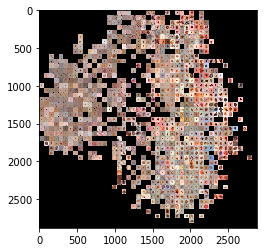

In [67]:
# drawing all images in a merged image
merged_width = int(np.ceil(np.sqrt(no_of_images))*image_width)
merged_image = np.zeros((merged_width, merged_width, 3), dtype='uint8')

for counter, index in enumerate(image_xindex_sorted):
    # set location
    if ellipside:
        a = np.ceil(reduced_transformed[counter, 0] * (merged_width-image_width-1)+1)
        b = np.ceil(reduced_transformed[counter, 1] * (merged_width-image_width-1)+1)
        a = int(a - np.mod(a-1,image_width) + 1)
        b = int(b - np.mod(b-1,image_width) + 1)
        if merged_image[a,b,0] != 0:
            continue
        image_address = image_names[counter]
        img = np.asarray(Image.open(image_address).resize((image_width, image_width)))
        merged_image[a:a+image_width, b:b+image_width,:] = img[:,:,:3]
    else:
        b = int(np.mod(counter, np.sqrt(no_of_images)))
        a = int(np.mod(counter//np.sqrt(no_of_images), np.sqrt(no_of_images)))
        image_address = image_names[index]
        img = np.asarray(Image.open(image_address).resize((image_width, image_width)))
        merged_image[a*image_width:(a+1)*image_width, b*image_width:(b+1)*image_width,:] = img[:,:,:3]

plt.imshow(merged_image)
plt.show()

In [68]:
merged_image = Image.fromarray(merged_image)
if ellipside:
    if feature_extraction == 'inception':
        merged_image.save('merged-ellipsoide-inception_new1.png')
        #merged_image.save('merged-%s-ellipsoide-inception.png'%image_path.split('/')[-2])
    elif feature_extraction == 'raw':
        merged_image.save('merged-%s-ellipsoide-raw.png'%image_path.split('/')[-2])
    else:
        merged_image.save('merged-%s-ellipsoide-vgg.png'%image_path.split('/')[-2])
else:
    merged_image.save('merged-%s.png'%image_path.split('/')[-2])
    if feature_extraction == 'inception':
        merged_image.save('merged-%s-inception.png'%image_path.split('/')[-2])
    elif feature_extraction == 'raw':
        merged_image.save('merged-%s-raw.png'%image_path.split('/')[-2])
    else:
        merged_image.save('merged-%s-vgg.png'%image_path.split('/')[-2])
'''
def loadImages(path):
    # return array of images

    imagesList = listdir(path)
    loadedImages = []
    for image in imagesList:
        img = PImage.open(path + image)
        loadedImages.append(img)

    return loadedImages

#path = "/path/to/your/images/"

# your images in an array
imgs = loadImages(image_path)

for img in imgs:
    # you can show every image
    img.show()
'''

'\ndef loadImages(path):\n    # return array of images\n\n    imagesList = listdir(path)\n    loadedImages = []\n    for image in imagesList:\n        img = PImage.open(path + image)\n        loadedImages.append(img)\n\n    return loadedImages\n\n#path = "/path/to/your/images/"\n\n# your images in an array\nimgs = loadImages(image_path)\n\nfor img in imgs:\n    # you can show every image\n    img.show()\n'

### T-SNE visulaization of the data 

#### Hurray ..... Inception does a better job
* If we look more close to the image by zooming in or check the saved image, we can clearly see that most of the data has been categorized in smaller clusters.
<br>
* First on top left corner we can see that most of the automobiles/cars are clustered together. Then on the right of that / upper right corner most trucks are combined together. Similarly below that comes planes. Whereas on left side below cars we can see all the ships are together. Followed by cats together just next to them. Then surprisingly all frogs are together on left side of the image. Lastly most of the horses on bottom left corner and bird on the right bottom corner.
<br>
* If we observer carefully the image pixel gradient in the image of frog is more uniform compared to other categories and hence the result accuracy is better with them. Making them look like better cluster.
<br>
* It’s kind of ironic to see binary classification between natural and man-made things. Upper half has been occupied by planes, automobiles/cars, ships, trucks whereas bottom half is more like horses, cats 7 birds. This might be because of similar colors that we use in the machinery products made by us. We can see a small dog has been put on the boundary of cars as it is wearing some red cloth making the histogram of red & white color similar to that of cars.
<br>
* Also the boundary between dogs & cats is not distinct or those clusters are not far away from each other as most of the pics of dogs (puppies) and of cats are similar in a way of their appearance like color and structure. As these are just 32x32 images hence a clear differentiation between these two wont established easily.
<br>
* Different orientations of ostrich head are perfectly clubbed together next to birds cluster on bottom right corner.
<br>
* The images of ships are kind of perfectly clustered on right, must because of the unique color gradient between white color of ships and blue color of water.


### Reference :
* https://arxiv.org/abs/1512.00567
* https://github.com/tensorflow/models/tree/master/research/inception
* https://www.tensorflow.org/tutorials/image_recognition
* http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf
* https://lvdmaaten.github.io/tsne/
* https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding
